In [4]:
import sys
print(sys.executable)
import os, io, pandas as pd, numpy as np, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


/opt/conda/envs/anaconda-2024.02-py310/bin/python


In [5]:
df = pd.read_csv('Weather Data.csv')

In [6]:
df.head()

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [7]:
# Normalize column names
df.columns = [c.strip().replace(" ", "_").replace("/", "_").replace("%", "pct").replace("-", "_") for c in df.columns]

In [8]:
df.head()

,Date_Time,Temp_C,Dew_Point_Temp_C,Rel_Hum_pct,Wind_Speed_km_h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [9]:
# Identify weather column
weather_col = None
for c in df.columns:
    if "weather" in c.lower():
        weather_col = c
        break
if weather_col is None:
    weather_col = df.columns[-1]
print("Target column:", weather_col)

Target column: Weather


In [10]:
df.Weather.value_counts()

Weather
Mainly Clear                               2106
Mostly Cloudy                              2069
Cloudy                                     1728
Clear                                      1326
Snow                                        390
Rain                                        306
Rain Showers                                188
Fog                                         150
Rain,Fog                                    116
Drizzle,Fog                                  80
Snow Showers                                 60
Drizzle                                      41
Snow,Fog                                     37
Snow,Blowing Snow                            19
Rain,Snow                                    18
Thunderstorms,Rain Showers                   16
Haze                                         16
Drizzle,Snow,Fog                             15
Freezing Rain                                14
Freezing Drizzle,Snow                        11
Freezing Drizzle                

In [11]:
# Simplify multi-labels
# Splits the string by commas (,)
# Takes only the first label (index 0)
# Removes extra spaces around it using .strip()
# ensures all values in df[weather_col] are strings (so .split() works safely).
df[weather_col] = df[weather_col].astype(str).apply(lambda x: x.split(",")[0].strip())

In [12]:
df.Weather.value_counts()

Weather
Mainly Clear        2106
Mostly Cloudy       2069
Cloudy              1728
Clear               1326
Snow                 457
Rain                 450
Rain Showers         191
Fog                  150
Drizzle              139
Snow Showers          64
Freezing Drizzle      27
Thunderstorms         27
Freezing Rain         22
Haze                  16
Moderate Snow          6
Freezing Fog           4
Snow Pellets           1
Moderate Rain          1
Name: count, dtype: int64

In [13]:
df.Weather=df.Weather.apply(lambda x: 'Clear' if 'Clear' in x else x)
df.Weather=df.Weather.apply(lambda x: 'Cloudy' if 'Cloudy' in x else x)
df.Weather=df.Weather.apply(lambda x: 'Snow' if 'Snow' in x else x)
df.Weather=df.Weather.apply(lambda x: 'Rain' if 'Rain' in x else x)
df.Weather=df.Weather.apply(lambda x: 'Fog' if 'Fog' in x else x)
df.Weather =df.Weather.apply(lambda x: 'other' if x in ['Drizzle', 'Haze','Freezing Drizzle','Thunderstorms'] else x)

In [14]:
# Parse datetime
date_col = None
for c in df.columns:
    if "date" in c.lower() or "time" in c.lower():
        date_col = c
        break
if date_col:
    df = df.rename(columns={date_col: "Date_Time"})
    df['Date_Time'] = pd.to_datetime(df['Date_Time'], errors='coerce', dayfirst=False)

In [15]:
df.Date_Time.nunique()

8784

In [16]:
# Time features
if 'Date_Time' in df.columns and df['Date_Time'].notna().any():
    df['Date_Time'] = pd.to_datetime(df['Date_Time'], errors='coerce')

    df['hour'] = df['Date_Time'].dt.hour
    df['month'] = df['Date_Time'].dt.month
    df['dayofweek'] = df['Date_Time'].dt.dayofweek
else:
    df['hour'] = 0; df['month'] = 0; df['dayofweek'] = 0

In [17]:
df.Date_Time.nunique()

8784

In [18]:
# Feature selection (same logic as before)
candidate_features = ['Temp_C', 'Dew_Point_Temp_C', 'Rel_Hum_pct', 'Wind_Speed_km_h', 'Visibility_km', 'Press_kPa', 'hour', 'month', 'dayofweek']
selected = []
for f in candidate_features:
    f_key = f.lower().replace("-", "_").replace(" ", "_")
    for c in df.columns:
        if c.lower().replace("-", "_").replace(" ", "_") == f_key:
            selected.append(c)
            break
if len(selected) < 4:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != weather_col]
    for f in candidate_features:
        for c in numeric_cols:
            if f.split('_')[0] in c.lower() and c not in selected:
                selected.append(c)
    for c in numeric_cols:
        if c not in selected and len(selected) < 6:
            selected.append(c)
selected = list(dict.fromkeys(selected))
print("Selected features:", selected)

X = df[selected]
y = df[weather_col]
data = pd.concat([X, y], axis=1)

Selected features: ['Temp_C', 'Dew_Point_Temp_C', 'Rel_Hum_pct', 'Wind_Speed_km_h', 'Visibility_km', 'Press_kPa', 'hour', 'month', 'dayofweek']


In [19]:
df.head()

,Date_Time,Temp_C,Dew_Point_Temp_C,Rel_Hum_pct,Wind_Speed_km_h,Visibility_km,Press_kPa,Weather,hour,month,dayofweek
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog,0,1,6
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog,1,1,6
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,other,2,1,6
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,other,3,1,6
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog,4,1,6


In [20]:
def LABEL_ENCODING(c1):
    from sklearn import preprocessing
    label_encoder = preprocessing.LabelEncoder()
    df[c1]= label_encoder.fit_transform(data[c1])
    df[c1].unique()
LABEL_ENCODING("Weather")
df

,Date_Time,Temp_C,Dew_Point_Temp_C,Rel_Hum_pct,Wind_Speed_km_h,Visibility_km,Press_kPa,Weather,hour,month,dayofweek
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,2,0,1,6
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,2,1,1,6
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,5,2,1,6
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,5,3,1,6
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,2,4,1,6
...,...,...,...,...,...,...,...,...,...,...,...
8779,2012-12-31 19:00:00,0.1,-2.7,81,30,9.7,100.13,4,19,12,0
8780,2012-12-31 20:00:00,0.2,-2.4,83,24,9.7,100.03,4,20,12,0
8781,2012-12-31 21:00:00,-0.5,-1.5,93,28,4.8,99.95,4,21,12,0
8782,2012-12-31 22:00:00,-0.2,-1.8,89,28,9.7,99.91,4,22,12,0


In [21]:
df = df.drop('Date_Time',axis=1)

In [22]:
X = df.drop('Weather',axis=1)
y = df['Weather']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6148, 9)
(2636, 9)
(6148,)
(2636,)


In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 42)
classifier.fit(X_train, y_train)

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [27]:
y_pred = classifier.predict(X_test)

In [28]:
y_pred

array([1, 1, 1, ..., 1, 0, 1])

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[634 369   1   4   5   0]
 [375 733   2  25  10   0]
 [  0   0  16  11  12   9]
 [  5  89   6  66  19  11]
 [  6  47   2   3 109   0]
 [  0   8   9  25  16   9]]


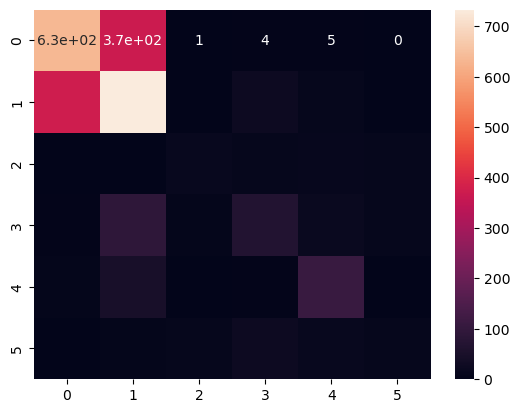

In [30]:
sns.heatmap(cm,annot=True)
plt.show()

In [31]:
acc1 = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc1}")

Accuracy score: 0.5944613050075872


In [32]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 42)
classifier.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [33]:
y_pred = classifier.predict(X_test)

In [34]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc2 = accuracy_score(y_test, y_pred)

[[648 356   2   3   4   0]
 [396 720   2  20   7   0]
 [  0   0  24  14   8   2]
 [  8  98   6  71  10   3]
 [  8  50   2   6 101   0]
 [  0  11  14  26  12   4]]


In [35]:
print(f"Accuracy score: {acc2}")

Accuracy score: 0.5948406676783005


In [36]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [37]:
y_pred = classifier.predict(X_test)

In [38]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[819 190   3   0   1   0]
 [270 854   1  13   6   1]
 [  0   3  29  10   5   1]
 [ 18  72   4  86   8   8]
 [ 11  45   0   4 102   5]
 [  0   8   5  17  13  24]]


In [39]:
acc3 = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc3}")

Accuracy score: 0.7261001517450683


In [40]:
# Drop NA rows
data = data.dropna()
X = data[selected].copy()
y = data[weather_col].copy()
print("After cleaning, rows:", X.shape[0], "unique classes:", y.nunique())

After cleaning, rows: 8784 unique classes: 6


In [41]:
#Training - Naive Bayes on the Training set

In [42]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [43]:
y_pred = classifier.predict(X_test)

In [44]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[664 295   1  24  26   3]
 [389 588   2 106  57   3]
 [  1   0  28   5   5   9]
 [  3  65  16  70  20  22]
 [  6  30   4   0 121   6]
 [  0   3  18  21  16   9]]


In [45]:
acc4 = accuracy_score(y_test, y_pred)
print(f"Accuracy score : {acc4}")

Accuracy score : 0.5614567526555387


# Training Decision Tree Classification on Train set

In [46]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [47]:
y_pred = classifier.predict(X_test)

In [48]:
y_pred

array([1, 1, 5, ..., 1, 0, 1])

In [49]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[747 252   0   7   5   2]
 [290 788   0  41  21   5]
 [  0   0  29  13   4   2]
 [ 12  58   9  93   9  15]
 [  8  35   1   8 112   3]
 [  1   5   9  19   9  24]]


<Axes: >

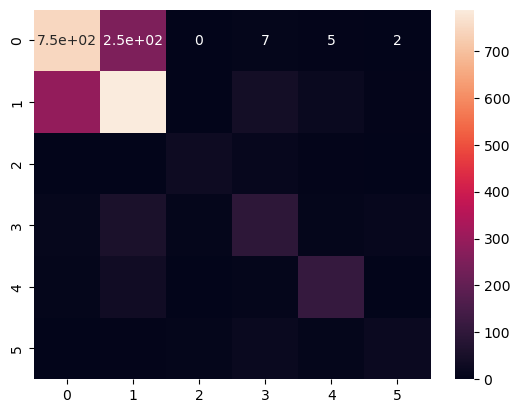

In [50]:
sns.heatmap(cm,annot=True)

In [51]:
acc5 = accuracy_score(y_test, y_pred)
print(f"Accuracy score: {acc5}")

Accuracy score: 0.6801972685887708


# Random Forest Classifier

In [52]:
from sklearn.ensemble import RandomForestClassifier
forest= RandomForestClassifier(n_estimators =40, random_state = 42)
forest.fit(X_train,y_train)
RandomForestClassifier(n_estimators=40, random_state=42)
y_pred = forest.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

<Axes: >

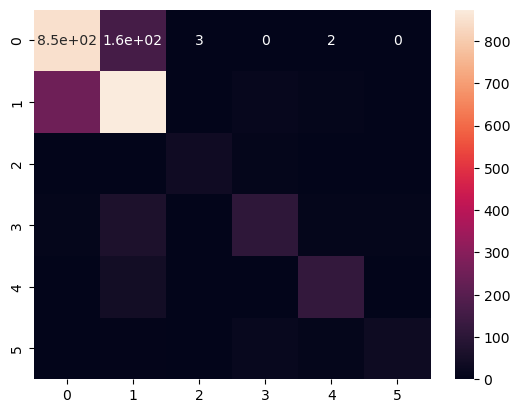

In [53]:
sns.heatmap(cm,annot=True)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80      1013
           1       0.76      0.76      0.76      1145
           2       0.82      0.75      0.78        48
           3       0.70      0.54      0.61       196
           4       0.82      0.71      0.76       167
           5       0.73      0.48      0.58        67

    accuracy                           0.76      2636
   macro avg       0.77      0.68      0.72      2636
weighted avg       0.76      0.76      0.76      2636



In [55]:
acc6 = forest.score(X_test,y_test)
print(acc6)

0.7647951441578149


Training XGBoost on the Training set

In [56]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

ModuleNotFoundError: No module named 'xgboost'

In [57]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

ModuleNotFoundError: No module named 'xgboost'

Making confusion matrix

In [58]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
acc7 = accuracy_score(y_test, y_pred)

[[747 252   0   7   5   2]
 [290 788   0  41  21   5]
 [  0   0  29  13   4   2]
 [ 12  58   9  93   9  15]
 [  8  35   1   8 112   3]
 [  1   5   9  19   9  24]]


In [59]:
print(acc7)

0.6801972685887708


In [60]:
# Create visualization for all model with their Accuracy

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


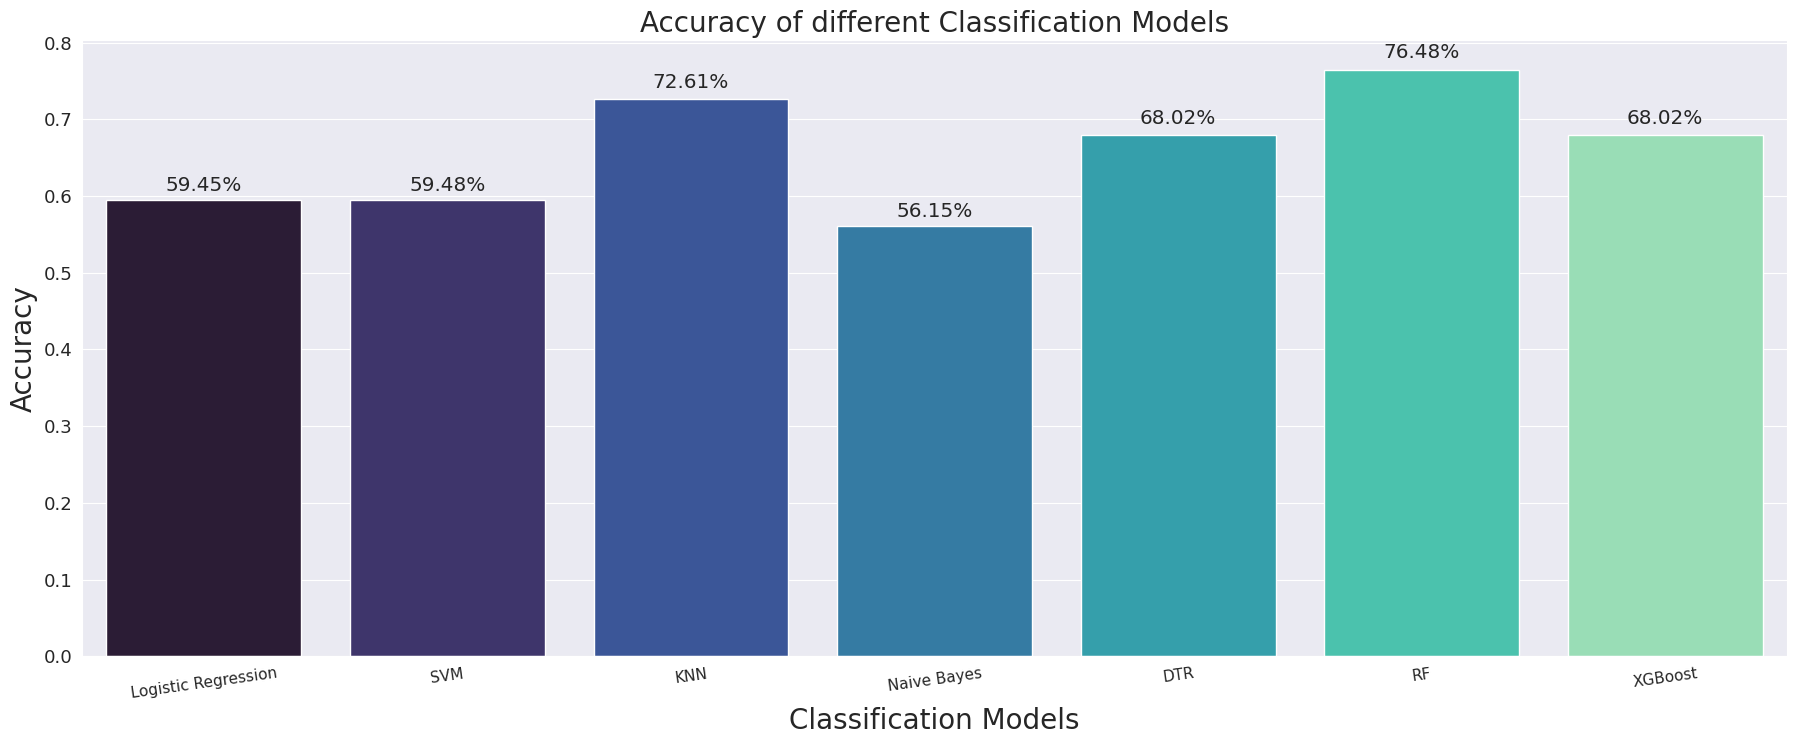

In [61]:
mylist=[]
mylist2=[]
mylist.append(acc1)
mylist2.append("Logistic Regression")
mylist.append(acc2)
mylist2.append("SVM")
mylist.append(acc3)
mylist2.append("KNN")
mylist.append(acc4)
mylist2.append("Naive Bayes")
mylist.append(acc5)
mylist2.append("DTR")
mylist.append(acc6)
mylist2.append("RF")
mylist.append(acc7)
mylist2.append("XGBoost")
plt.rcParams['figure.figsize']=8,6
sns.set_style("darkgrid")
plt.figure(figsize=(22,8))
ax = sns.barplot(x=mylist2, y=mylist, palette = "mako", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 11, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()